### Project 3 - Using Deep Learning To Clone Driver Behavior

This project begins with collecting training data using a Udacity vehicle driving simulator that creates images from three cameras in the car, center, left and right locations.   The car is driven around the track with a joystick or keyboard arrows.  The images that are collected are pre processed to remove some of the straight steering wheel angles to help the car turn when necessary, normalization for speed in compiling the model, cropping the picture for relevant range, and resizing the image to make it similar to the NVIDIA model I emulated.  After the preprocessing is completed the images are trained with a keras convolutional neural network.  A keras fit_generator is used in this project.

We start by importing packages necessary to train the data from the simulator.


In [1]:
"""
Steering angle prediction model
"""

#importing some useful packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
from PIL import Image
import keras
import math
import random
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adam, RMSprop
from scipy.misc.pilutil import imresize
from sklearn.utils import shuffle
import cv2

import os
import argparse
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.callbacks import ModelCheckpoint


Using TensorFlow backend.


##### Read in the file paths to the images and steering angles

In [2]:
import pandas as pd
data = pd.read_csv('driving_log.csv', header = None)
data.columns = ["center_images","left_images","right_images","steering","brake","throttle","speed"]
len(data)

8309

In [3]:
X_train = np.copy(data['center_images']+':'+data['left_images']+':'+data['right_images'])
Y_train = np.copy(data['steering'])

In [4]:
len(X_train)

8309

##### One image is read in from the simulator.  It is plotted below.

This image is: <class 'numpy.ndarray'> with dimesions: (160, 320, 3)


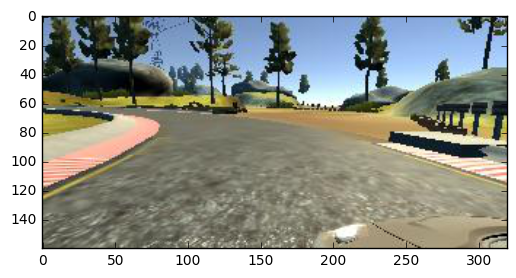

In [5]:
#reading in an image
image = mpimg.imread('IMG/left_2016_12_01_13_31_13_584.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  

##### Cut 20% of the bottom of the image and 25 pixels from the top

The cropped image is show below.

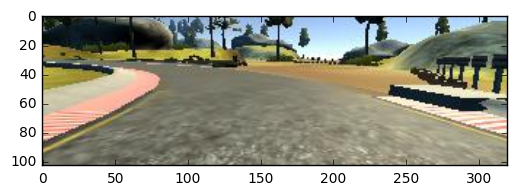

In [6]:
oriimage = mpimg.imread('IMG/left_2016_12_01_13_31_13_584.jpg', 1)
#crop face before resize
# crop 20% from bottom to remove car hood and 25 pixels from top
crop_face = oriimage[32:135, :] 
plt.imshow(crop_face)

In [7]:
crop_face.shape

(103, 320, 3)

##### Resize the image from (103, 320, 3) to (66, 208, 3)

The resized image is plotted below.

In [8]:
#Resize to image to half or 65% of cropped image
newimage = imresize(crop_face, .65, interp='bilinear', mode=None)
newimage.shape

(66, 208, 3)

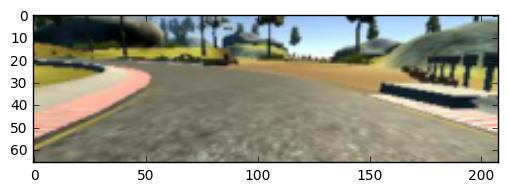

In [9]:
plt.imshow(newimage)

In [10]:
type(oriimage[0][0][0])

numpy.uint8

In [11]:
oriimage = oriimage/255 - .5

In [12]:
type(oriimage[0][0][0])

numpy.float64

In [13]:
np.max(oriimage)

0.5

##### This is the type image that is sent to the drive.py file.  The image colors match.

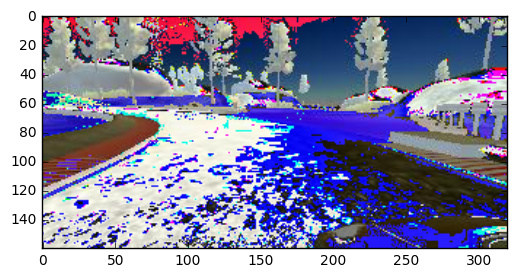

In [14]:
#color type image sent to the fit_generator 
# that matches the drive.py color images
plt.imshow(oriimage)

##### Normalization, Cropping and Resizing in one function

The load_image function takes the file path to the image.  The image is read into 
memory.  The image is cropped to remove the hood of the car and part of the sky
area.  The image is then resized to get a image similar to the NVIDIA image.

In [15]:
def load_image(imagepath):
    
    oriimage = mpimg.imread(imagepath, 1)
    #crop face before resize
    #Remove 20% from the bottom to eliminate the car hood
    # 25 pixels from the top to concentrate on the road
    crop_face = oriimage[32:135, :]
    #Resize to image to half or 65% of cropped image
    newimage = imresize(crop_face, .65, interp='bilinear', mode=None)
    newimage = newimage/255-0.5
    return newimage

##### Augment the image for the left and right camera

These right and left camera images are offset to
match the center camera images used in drive.py

In [16]:
def trans_image(image,steer,trans_range):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(208,66))
    return image_tr,steer_ang

##### Flip the image horizontially.

In [17]:
def flip_image(image):
    flipimage = np.fliplr(image)
    return flipimage

##### The flipped image is shown below

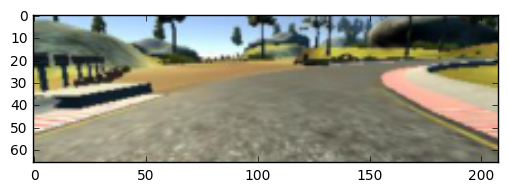

In [18]:
flipimage = np.fliplr(newimage)
plt.imshow(flipimage)

In [19]:
nb_epoch = 7
number_of_rows = 8032
image_rows = 66
image_columns = 208
image_channels = 3
#batch_images = np.zeros((number_of_rows, image_rows, image_columns, image_channels))
#batch_steering = np.zeros(number_of_rows)

##### Remove Half of Near Zero Steering Angles From The Training Data

In [20]:
def remove_low_steering_angles(x,y): 
    image = []
    steer_angle = []
    for xi, yi in zip(x, y):
        probability = random.random()
        if (probability > 0.5 or abs(yi) > 0.01):
            image.append(xi)
            steer_angle.append(yi)

    image = np.array(image)
    steer_angle = np.array(steer_angle)
    return image, steer_angle

In [21]:
x_train_less, y_train_less = remove_low_steering_angles(X_train,Y_train)

##### The Custom Batch Generator

The batchgen generator runs continuously and yields a batch size of on to the  fit_generator.  This generator also includes randomly selecting center, right or camera image.  The train input data is shuffled after each epoch.  Half of images of each epoch are horizontally flipped to provide more image data.  This is where I learned the powerful python generator.

In [22]:
def batchgen(X,Y):
    
    trans_range = 100
    steer_angle = []
    counter  = 0 
    while counter < len(X):
        
         
        if counter==len(X):
            counter  = 0
            X, Y = shuffle(X, Y, random_state=0)
        for counter in range(len(X)): 
            y = Y[counter]
           
            if y <  0.01:
                chance = random.random()
                if chance > 0.75:
                    imagepath = X[counter].split(':')[2]
                    image = load_image(imagepath)
                    image, y = trans_image(image,y,trans_range)
                    y = y - .25
                else:
                    if chance > 0.49:
                        imagepath = X[counter].split(':')[2]
                        image = load_image(imagepath)
                        image, y = trans_image(image,y,trans_range)
                        y = y - .25
                    else:
                        if chance > 24:
                            imagepath = X[counter].split(':')[0]
                            image = load_image(imagepath)
                          
                        else:
                            imagepath = X[counter].split(':')[0]
                            image = load_image(imagepath)
                            
            elif y > 0.01:
                chance = random.random()
                if chance > 0.75:
                    imagepath = X[counter].split(':')[1]
                    image = load_image(imagepath)
                    image, y = trans_image(image,y,trans_range)
                    y = y + .25
                else:
                    if chance > 0.49:
                        imagepath = X[counter].split(':')[1]
                        image = load_image(imagepath)
                        image, y = trans_image(image,y,trans_range)
                        y = y + .25
                    else:
                        if chance > 0.24:
                            imagepath = X[counter].split(':')[0]
                            image = load_image(imagepath)
                      
                        else:
                            imagepath = X[counter].split(':')[0]
                            image = load_image(imagepath)
                     
                                    
            else:
                imagepath = X[counter].split(':')[0]
                image = load_image(imagepath)
                  
            
            y = np.array([[y]])
                
            if np.random.choice([True, False]):
                image = flip_image(image)
                y = -y
            
            image = image.reshape(1, image_rows, image_columns, image_channels)
            yield image, y  
            
        
      

##### First Convolution Layer - conv1

For the input planes with a shape of 66x208x3, (HxWxD)
conv1 has 24 filters of shape 5x5x3 (HxWxD)
A stride of 2 for both the height and width (S)
Same padding of size 1 (P)
The formula for calculating the new output height or width of conv1 layer is:
    
new_height = (input_height - filter_height + 2 * P)/S + 1
new_width = (input_width - filter_width + 2 * P)/S + 1

**new_height = (66-5 +2*1)/2 +1 = 33**
**new_width = (208-5+2*1)/2 + 1 = 104**

Output shape of conv1 layer is (33, 104, 24)
To calculate the parameters with parameter sharing, each neuron in an output channel shares its weights with every other neuron in that channel. So the number of parameters is equal to the number of neurons in the filter, plus a bias neuron, all multiplied by the number of channels in the output layer.

**Parameters =  (5 x 5 x 3 + 1 ) * 24 = 1824**

##### Second Convolution Layer - conv2

For the input planes with a shape of 33x104x24, (HxWxD)

conv2 has 36 filters of shape 5x5x24 (HxWxD)

A stride of 2 for both the height and width (S)

Same padding of size 2 (P)

The formula for calculating the new output height or width of conv1 layer is:

**new_height = (33-5 +2*2)/2 +1 = 17**

**new_width = (104-5+2*2)/2 + 1 = 52**

Output shape of conv1 layer is **(17, 52, 36)**
Parameters =  (5 x 5 x 24 + 1 ) *36  = 21636

##### Third Convolution Layer - conv3

For the input planes with a shape of 17x52x36

conv3 has 48 filters of shape 5x5x36 (HxWxD)

A stride of 2 for both the height and width (S)

Valid padding of size 1 (P)

The new output height or width of conv1 layer is:

**new_height = (17-5 +2*1)/2 +1 = 8**

I calculate 8, the model.summary() calculates 7.  This may be based on rounding up or down on the 0.5.  I do not know why the model does not match this answer.  I will use the model.summary() 7 for the new_height.

**new_width = (52-5+2*1)/2 + 1 = 25**
I calculate 25 model.summary() calculates 24. I am sure I am right, but I am going to use model.summary() result.

Output shape of conv1 layer is **(7, 24, 48)**

Parameters =  (5 x 5 x 36 + 1 ) * 48  = 43,248

##### Fourth Convolution Layer - conv4

For the input planes with a shape of 7x24x48

conv4 has 64 filters of shape 3x3x48 (HxWxD)

A stride of 1 for both the height and width (S)

Valid padding of size 1 (P)

The new output height or width of conv4 layer is:

**new_height = (7-3 +1*1)/1 +1 = 4**
I calculate 4, the model.summary() calculates 5.  I do not know why the model does not match this answer.  I will use the model.summary 5 for the new_height.

**new_width = (24-3+2*1)/1+ 1 = 24**

I calculate 24, the model.summary() calculates 22.  I do not know why the model does not match this answer.  I will use the model.summary 5 for the new_height.

Output shape of conv1 layer is **(5, 22, 64)**

Parameters =  (3 x 3 x 48 + 1 ) * 64  = 27,712

##### Fifth Convolution Layer - conv5

For the input planes with a shape of 5x22x64

conv4 has 64 filters of shape 3x3x64 (HxWxD)

A stride of 1 for both the height and width (S)

Valid padding of size 1 (P)

The new output height or width of conv5 layer is:

**new_height = (5-3 +1*1)/1 +1 = 4**

I calculate 4, the model.summary() calculates 3.  I do not know why the model does not match this answer.  I will use the model.summary 3 for the new_height.

**new_width = (22-3+1*1)/1+ 1 = 21**

model.summary() calculates 20.  (model.summary only uses even numbers for the last two numbers in the output shape)

Output shape of conv5 layer is **(3, 20, 64)**

Parameters =  (3 x 3 x 64 + 1 ) * 64  =  36,928

##### Flatten
The output shape of conv5, (3, 20, 64) is flattened to 3840 neurons.

##### Fully Connected Layers
There are four fully connected hidden layers in this model



In [30]:
def get_model():
    input_shape = (image_rows, image_columns, image_channels)
    model = Sequential()
    model.add(Convolution2D(24,5,5, input_shape=input_shape, subsample = (2,2),
                        border_mode='same',
                        name='conv1', init='he_normal'))
    model.add(ELU())

    model.add(Convolution2D(36,5,5, subsample = (2,2),
                        border_mode='same',
                        name='conv2', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(48,5,5, subsample = (2,2),
                        border_mode='valid',
                        name='conv3', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(64,3,3, subsample = (1,1),
                        border_mode='valid',
                        name='conv4', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(64,3,3, subsample = (1,1),
                        border_mode='valid',
                        name='conv5', init='he_normal'))
    model.add(ELU())
    model.add(Flatten())
    model.add(Dense(100,name='hidden1', init='he_normal'))
    model.add(ELU())
    model.add(Dense(50,name='hidden2', init='he_normal'))
    model.add(ELU())
    model.add(Dense(10,name='hidden3',init='he_normal'))
    model.add(ELU())
    model.add(Dense(1, name='output', init='he_normal'))
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss='mse')
    return model

In [ ]:
model = get_model()

In [ ]:
samples_per_epoch = len(x_train_less)

In [ ]:
# checkpoint
checkpoint = ModelCheckpoint("model-{epoch:02d}.h5", monitor='loss', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]


In [ ]:
max_q_size = 32

#### The Incredible fit_generator

The keras fit_generator function is mainly used to save memory space.  A custom generator was created
to send a batch size of one to the keras fit_generator.  Fit_generators has some great features that
were used in the this project.  The callbacks function in the fit_generator is used to save the weights after each epoch.  The weights of each epoch may be run on the simulator to determine which works best.  I found one thousands ways where the keras model did not work.  Fit_generator allows you to use the same custom generator for validation data and training data. The nb_val_samples attribute is  only relevant if validation_data is a generator. It is the number of samples to use from validation generator at the end of every epoch. 


In [ ]:
history = model.fit_generator(batchgen(x_train_less, y_train_less), samples_per_epoch = samples_per_epoch, nb_epoch = nb_epoch,
                    verbose=1, max_q_size = max_q_size, callbacks=callbacks_list, validation_data=None, class_weight=None,
                     pickle_safe=False)

##### The seventh epoch provides the optimum weights for this model.  The weights are saved for each epoch.

Epoch 1/7
5852/5853 [============================>.] - ETA: 0s - loss: 0.0535
Epoch 00000: saving model to model-00.h5
5853/5853 [==============================] - 69s - loss: 0.0534    
Epoch 2/7
5852/5853 [============================>.] - ETA: 0s - loss: 0.0404
Epoch 00001: saving model to model-01.h5
5853/5853 [==============================] - 66s - loss: 0.0404    
Epoch 3/7
5852/5853 [============================>.] - ETA: 0s - loss: 0.0326
Epoch 00002: saving model to model-02.h5
5853/5853 [==============================] - 66s - loss: 0.0326    
Epoch 4/7
5852/5853 [============================>.] - ETA: 0s - loss: 0.0283
Epoch 00003: saving model to model-03.h5
5853/5853 [==============================] - 66s - loss: 0.0283    
Epoch 5/7
5852/5853 [============================>.] - ETA: 0s - loss: 0.0282
Epoch 00004: saving model to model-04.h5
5853/5853 [==============================] - 66s - loss: 0.0282    
Epoch 6/7
5852/5853 [============================>.] - ETA: 0s - loss: 0.0270
Epoch 00005: saving model to model-05.h5
5853/5853 [==============================] - 66s - loss: 0.0270    
Epoch 7/7
5852/5853 [============================>.] - ETA: 0s - loss: 0.0263
Epoch 00006: saving model to model-06.h5
5853/5853 [==============================] - 66s - loss: 0.0263    

##### model.summary() keras command provides the following output:
___________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     

conv1 (Convolution2D)            (None, 33, 104, 24)   1824        convolution2d_input_1 
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 33, 104, 24)   0           conv1                     
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 17, 52, 36)    21636       elu_1                     
____________________________________________________________________________________________________
elu_2 (ELU)                      (None, 17, 52, 36)    0           conv2                     
____________________________________________________________________________________________________
conv3 (Convolution2D)            (None, 7, 24, 48)     43248       elu_2                     
____________________________________________________________________________________________________
elu_3 (ELU)                      (None, 7, 24, 48)     0           conv3                      
____________________________________________________________________________________________________
conv4 (Convolution2D)            (None, 5, 22, 64)     27712       elu_3                      
____________________________________________________________________________________________________
elu_4 (ELU)                      (None, 5, 22, 64)     0           conv4                    
____________________________________________________________________________________________________
conv5 (Convolution2D)            (None, 3, 20, 64)     36928       elu_4                     
____________________________________________________________________________________________________
elu_5 (ELU)                      (None, 3, 20, 64)     0           conv5                     
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 3840)          0           elu_5                     
____________________________________________________________________________________________________
hidden1 (Dense)                  (None, 100)           384100      flatten                
____________________________________________________________________________________________________
elu_6 (ELU)                      (None, 100)           0           hidden1                    
____________________________________________________________________________________________________
hidden2 (Dense)                  (None, 50)            5050        elu_6                      
____________________________________________________________________________________________________
elu_7 (ELU)                      (None, 50)            0           hidden2                   
____________________________________________________________________________________________________
hidden3 (Dense)                  (None, 10)            510         elu_7                      
____________________________________________________________________________________________________
elu_8 (ELU)                      (None, 10)            0           hidden3                  
____________________________________________________________________________________________________
output (Dense)                   (None, 1)             11          elu_8                     

Total params: 521,019
Trainable params: 521,019
Non-trainable params: 0


In [ ]:
model.summary()

##### The model and weights are saved with the following code.

In [ ]:


model.save_weights("model.h5", True)
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)
    
print("Saved model weights and configuration file.")